In [15]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")


In [17]:
orders = pd.read_csv("orders.csv")

print("Orders Shape:", orders.shape)
orders.head()


Orders Shape: (10000, 6)


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name
0,1,2508,450,18-02-2023,842.97,New Foods Chinese
1,2,2693,309,18-01-2023,546.68,Ruchi Curry House Multicuisine
2,3,2084,107,15-07-2023,163.93,Spice Kitchen Punjabi
3,4,319,224,04-10-2023,1155.97,Darbar Kitchen Non-Veg
4,5,1064,293,25-12-2023,1321.91,Royal Eatery South Indian


In [18]:
orders.info()
orders.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_id         10000 non-null  int64  
 1   user_id          10000 non-null  int64  
 2   restaurant_id    10000 non-null  int64  
 3   order_date       10000 non-null  object 
 4   total_amount     10000 non-null  float64
 5   restaurant_name  10000 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 468.9+ KB


,0
order_id,0
user_id,0
restaurant_id,0
order_date,0
total_amount,0
restaurant_name,0


In [19]:
# Convert date column (adjust name if needed)
orders["order_date"] = pd.to_datetime(orders["order_date"])


/tmp/ipython-input-3096154051.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  orders["order_date"] = pd.to_datetime(orders["order_date"])


In [20]:
users = pd.read_json("users.json")

print("Users Shape:", users.shape)
users.head()


Users Shape: (3000, 4)


,user_id,name,city,membership
0,1,User_1,Chennai,Regular
1,2,User_2,Pune,Gold
2,3,User_3,Bangalore,Gold
3,4,User_4,Bangalore,Regular
4,5,User_5,Pune,Gold


In [21]:
users.info()
users.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     3000 non-null   int64 
 1   name        3000 non-null   object
 2   city        3000 non-null   object
 3   membership  3000 non-null   object
dtypes: int64(1), object(3)
memory usage: 93.9+ KB


,0
user_id,0
name,0
city,0
membership,0


In [24]:
# Create in-memory SQLite DB
conn = sqlite3.connect(":memory:")

# Read SQL file
with open("restaurants.sql", "r", encoding="utf-8") as file:
    sql_script = file.read()

# Execute SQL script
conn.executescript(sql_script)

# Load restaurants table into pandas
restaurants = pd.read_sql("SELECT * FROM restaurants", conn)

print("Restaurants Shape:", restaurants.shape)
restaurants.head()

Restaurants Shape: (500, 4)


,restaurant_id,restaurant_name,cuisine,rating
0,1,Restaurant_1,Chinese,4.8
1,2,Restaurant_2,Indian,4.1
2,3,Restaurant_3,Mexican,4.3
3,4,Restaurant_4,Chinese,4.1
4,5,Restaurant_5,Chinese,4.8


In [25]:
merged_df = orders.merge(
    users,
    on="user_id",
    how="left"
)


In [26]:
merged_df = merged_df.merge(
    restaurants,
    on="restaurant_id",
    how="left"
)

print("Final Dataset Shape:", merged_df.shape)
merged_df.head()


Final Dataset Shape: (10000, 12)


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name_x,name,city,membership,restaurant_name_y,cuisine,rating
0,1,2508,450,2023-02-18,842.97,New Foods Chinese,User_2508,Hyderabad,Regular,Restaurant_450,Mexican,3.2
1,2,2693,309,2023-01-18,546.68,Ruchi Curry House Multicuisine,User_2693,Pune,Regular,Restaurant_309,Indian,4.5
2,3,2084,107,2023-07-15,163.93,Spice Kitchen Punjabi,User_2084,Chennai,Gold,Restaurant_107,Mexican,4.0
3,4,319,224,2023-10-04,1155.97,Darbar Kitchen Non-Veg,User_319,Bangalore,Gold,Restaurant_224,Chinese,4.8
4,5,1064,293,2023-12-25,1321.91,Royal Eatery South Indian,User_1064,Pune,Regular,Restaurant_293,Italian,3.0


In [27]:
assert merged_df.shape[0] == orders.shape[0]


In [30]:
merged_df.to_csv("final_food_delivery_dataset.csv", index=False)
print("final_food_delivery_dataset.csv saved successfully")


final_food_delivery_dataset.csv saved successfully


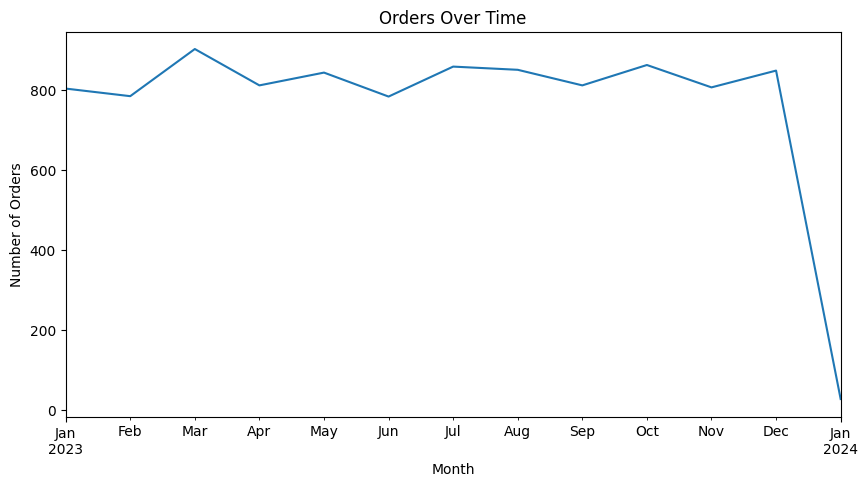

In [29]:
orders_by_month = (
    merged_df
    .groupby(merged_df["order_date"].dt.to_period("M"))
    .size()
)

orders_by_month.plot(kind="line", figsize=(10,5), title="Orders Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.show()


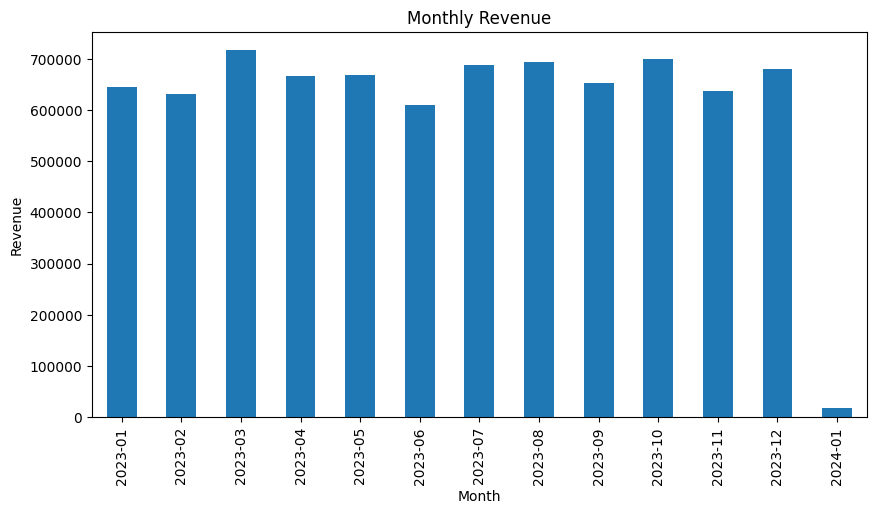

In [33]:
revenue_by_month = (
    merged_df
    .groupby(merged_df["order_date"].dt.to_period("M"))["total_amount"]
    .sum()
)

revenue_by_month.plot(kind="bar", figsize=(10,5), title="Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

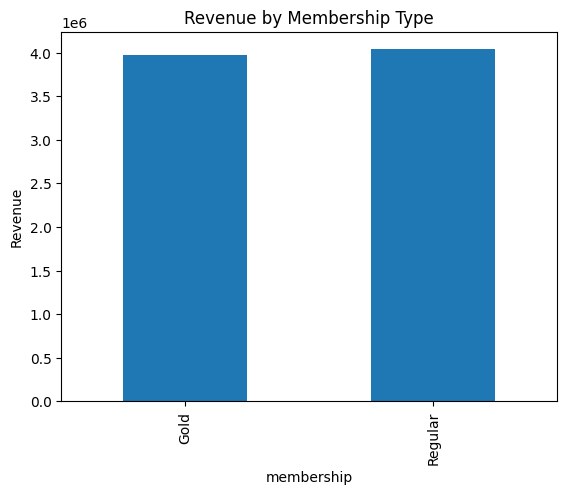

In [35]:
membership_revenue = merged_df.groupby("membership")["total_amount"].sum()
membership_revenue.plot(kind="bar", title="Revenue by Membership Type")
plt.ylabel("Revenue")
plt.show()

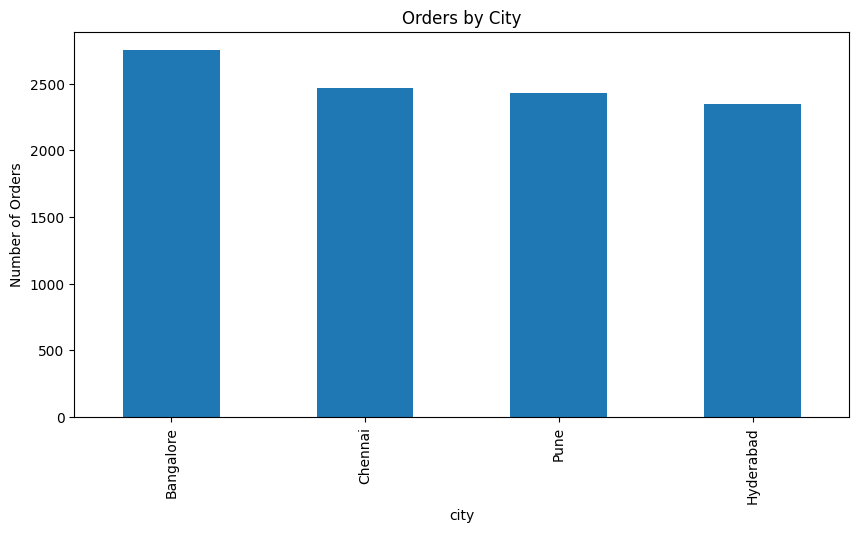

In [36]:
city_orders = merged_df.groupby("city").size().sort_values(ascending=False)

city_orders.plot(kind="bar", figsize=(10,5), title="Orders by City")
plt.ylabel("Number of Orders")
plt.show()


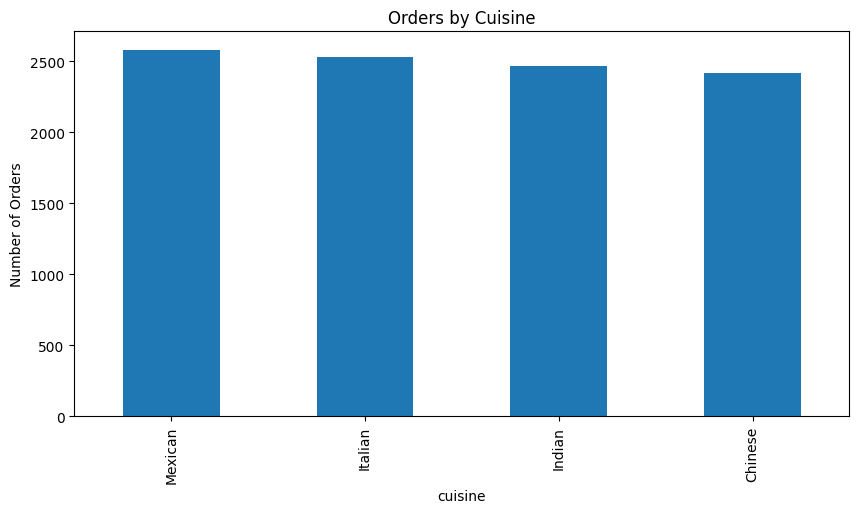

In [37]:
cuisine_orders = merged_df.groupby("cuisine").size().sort_values(ascending=False)

cuisine_orders.plot(kind="bar", figsize=(10,5), title="Orders by Cuisine")
plt.ylabel("Number of Orders")
plt.show()


In [38]:
orders_per_user = merged_df.groupby("user_id").size()

repeat_users = (orders_per_user > 1).sum()
one_time_users = (orders_per_user == 1).sum()

pd.DataFrame({
    "User Type": ["Repeat Users", "One-Time Users"],
    "Count": [repeat_users, one_time_users]
})


,User Type,Count
0,Repeat Users,2539
1,One-Time Users,344
